<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint7/Module1/DS_231_guided_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---


# Define ML Problems
- Data Leakage
- ROC/AUC Curve



In [4]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # new imports for ROCAUC curve
from sklearn.metrics import classification_report, roc_curve, ConfusionMatrixDisplay, \
    RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

In [5]:
plot_confusion_matrix = ConfusionMatrixDisplay.from_estimator
plot_roc_curve = RocCurveDisplay.from_estimator

In [6]:
pd.set_option('display.max_columns', 500)

# Define ML problems

# I. Wrangle Data

In [7]:
DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'

pd.read_csv(DATA_PATH + 'burritos/burritos.csv')

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Valentine's Mexican Food,Al Pastor,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,3.50,NaN,Anon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,Valentine's Mexican Food,Chile Relleno,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,6.00,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,4.00,NaN,Bonnie,non-symmetric wrapping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,Valentine's Mexican Food,California,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,7.90,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,3.50,NaN,Scott,way too small and not enough meat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,Valentine's Mexican Food,Shrimp,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,7.90,3.0,NaN,NaN,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,4.00,NaN,AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def wrangle(filepath):

    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')

    # drop rows with no overall rating
    df.dropna(subset=['overall'], inplace=True)

    # Create `'great'` column as target. if burrito rating >= 4 then it's a 1.
    df['great'] = (df['overall'] >= 4).astype(int)

    # Drop overall column to prevent data leakage, because training data contains info on the target.
    df.drop(columns='overall', inplace=True)

    # CLEAN BINARY-ENCODED COLUMNS
    # first we select all the categorical columns
    categorical_cols = df.select_dtypes('object').columns

    # then we use categorical columns which have to be binary encoded, and choose those with unique values that are less than 4
         # which are x, X and NaN, basically all the ingredients columns
    binary_cols = [col for col in categorical_cols if df[col].nunique() < 4]

    # then apply lambda function to these columns (instead of writing a for loop and an if statement to do something to a column, we can apply a lambda function)
         # check if each value is a string or not, if yes then 1, if not then 0
         # isinstance function returns True if a specified object is of a specific type given, which is string in our case
    for col in binary_cols:
        df[col] = df[col].apply(lambda x: 1 if isinstance(x, str) else 0)

    # Drop high-cardinality categorical variables
    threshold = 20

    high_card_cols = [col for col in categorical_cols
                      if df[col].nunique() > threshold]
    df.drop(high_card_cols, axis=1, inplace=True)

    # Dropping columns with high number of NaN values
    df.dropna(axis=1, thresh=300, inplace=True)

    return df

In [10]:
df = wrangle(DATA_PATH + 'burritos/burritos.csv')
df.head()

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-27,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# II. Split Data

In [11]:
target = 'great'
y = df[target]
X = df.drop(target, axis=1)

In [ ]:
# we're working with a classification problem today. Burrito is either great or not great. We need to check if data set is balanced or not.
# we can use classification if the majority is 50-70%
# We can even generate synthetic data from the minority class using a SMOTE technique

##If we have an imbalanced data set for a classification model:
###SMOTE Synthetic Minority Oversampling Technique:
SMOTE creates synthetic points of data from existing data points by drawing a line between those points and creating new data points within those lines. While this doesn't add any new info to the model, this can provide a balanced approach to oversampling data. For more details, scroll down to the bottom of this notebook.

<Axes: >

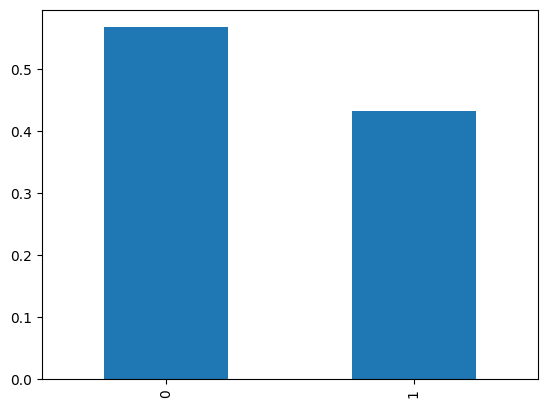

In [12]:
y.value_counts(normalize=True).plot(kind='bar')

<Axes: >

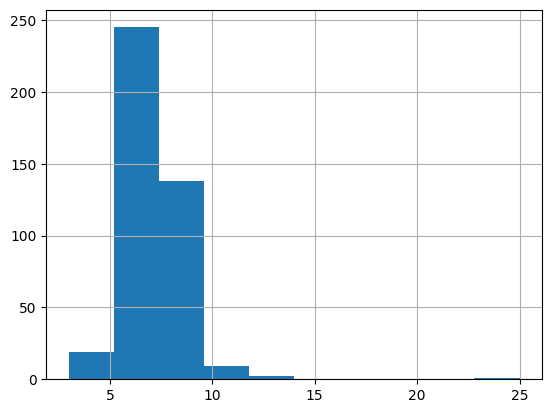

In [13]:
# if it's a regression task, you'll have to check whether the data is skewed
X['Cost'].hist()

## If we have skewed data for a regression model:
- if our data is skewed, then we have more data to train on much larger samples belonging to a certain range, less likely to successfully predict the target of samples that belong to the tail end of the range
- we need to bring the tail end values back to the the center, we can do so by applying log tranform to make it look more normally distributed, use that column as the target, train the model and get predictions, then transform the values back to their original scale and evaluate model. Scroll to the bottom of notebook for more details.

In [ ]:
# but today we're working with a classification problem

In [15]:
# use resampling techqniue on time-series data
# it's necessary when you're given dataset in a recorded time interval and you want to change the time interval to something else. e.g.
#  aggregate monthly data into EOD dadta, or you can up sample hourly data into minute by minute data
y.resample('y').sum() # resample by year, aggregated by year

Date
2011-12-31      0
2012-12-31      0
2013-12-31      0
2014-12-31      0
2015-12-31      1
2016-12-31    121
2017-12-31     38
2018-12-31     13
2019-12-31      8
2020-12-31      0
2021-12-31      0
2022-12-31      0
2023-12-31      0
2024-12-31      0
2025-12-31      0
2026-12-31      1
Freq: A-DEC, Name: great, dtype: int64

In [17]:
# we have about 170 samples in total. 80% in 2016, 15% in 2017, something wrong with that 1 observation in 2026 so we might wanna delete that down the road?
# first cutoff can be 2017. Anything prior 2017 can be in training set, everything in 2017 for validation, and after 2017 for test set.

In [18]:
# splitting data into 3 sets based on chronological order
# Training

train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# Validation
validation_mask = X.index.year == 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

# Testing
test_mask = X.index.year > 2017
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

# III. Establish Baseline

In [19]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5906040268456376


# IV. Build Model

In [20]:
# Model 1: Logistic Regression

# no encoder, because the dataset today is entirely numerical in nature
# scaling helps model isn't biased towards columns that use large numbers, we only use it for distance-based linear models not for our decision-based tree models
model_lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [21]:
# Model 2: Random Forest
model_rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1)
)

model_rf.fit(X_train, y_train);

# V. Check Metrics

**Accuracy**

accuracy = (tp + tn) / (tp + fp + tn + fn)
- all the true values divided by everything

In [23]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.912751677852349
Validation Accuracy (LOGR): 0.788235294117647


In [24]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8588235294117647


**Precision, Recall, F1**

precision = tp / (tp + fp)


recall = tp / (tp + fn)

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.70      0.79        47
           1       0.71      0.89      0.79        38

    accuracy                           0.79        85
   macro avg       0.80      0.80      0.79        85
weighted avg       0.81      0.79      0.79        85



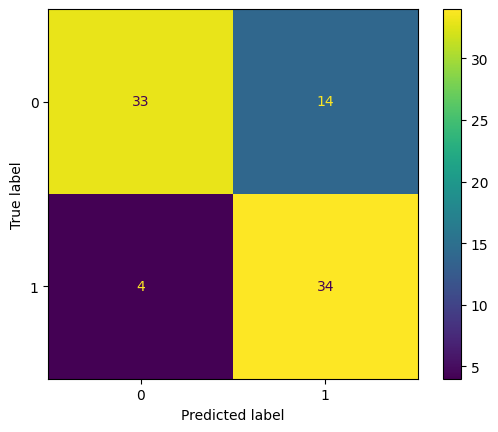

In [29]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val);

# Our recall is 89 and precision is 71, our false positives are much higher than our false neg, aka trouble classifying burritos that aren't great

Random Forest
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        47
           1       0.81      0.89      0.85        38

    accuracy                           0.86        85
   macro avg       0.86      0.86      0.86        85
weighted avg       0.86      0.86      0.86        85



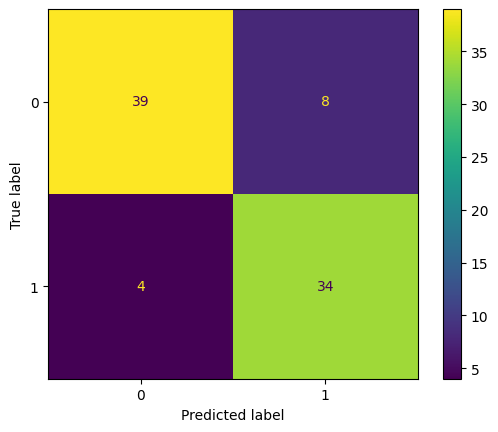

In [30]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val);

# Recall is 89, precision is 81, a lot less false pos


### Which should we choose?
- Remember the sigmoid curve and default 0.5 as the decision threshold? We can lower or increase the classification threshold. But a lot of times 0.5 is not a good number because often the class distribution might be severely skewed, in imbalanced classification problem.
- If we increase the threshold, we favor precision (example: saving money instead of lives) as our false negatives increase (example: sick patients missed)
- If we decrease threshold, we favor recall and false positives increase.

**ROC curve** to determine the best threshold


TPR = Recall = Sensitivity

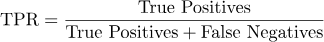

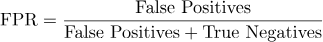

In [31]:
# the denominators are exactly opposite to each other


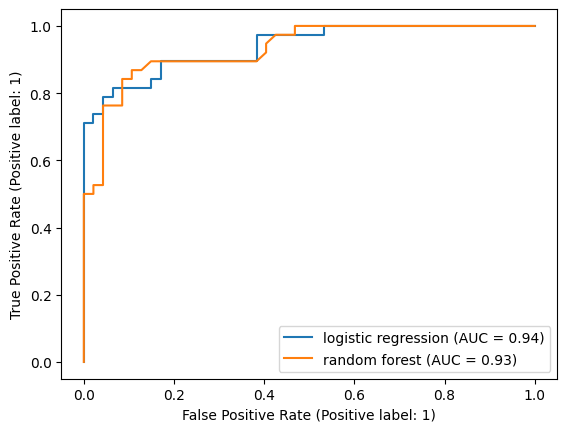

In [34]:
lr = plot_roc_curve(
    model_lr,
    X_val,
    y_val,
    name='logistic regression'
)

rf = plot_roc_curve(
    model_rf,
    X_val,
    y_val,
    ax= lr.ax_, # to have a common axis as LR
    name='random forest'
)

- both model curves are pretty close
- for this we calculate the **AUC score**, it's just the area under the ROC curve
- the AUC value calculates the probability that the model ranks a random positive sample, more highly than a random negative sample.
- AUC increase if we're better at identifying false positives and false neg, and not only predicting the majority class
- ranges from 0 to 1. if AUC is 0.7 means there's a 70% chance that we can distinguish the positive from the neg class

In [35]:
# the actual y values, and the probabilities from the model for positive
# AUC SCORE FOR RANDOM FOREST
roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,-1]) # we want the probabilty of the sample belonging to the positive class, meaning burrito is going to be great
# although it's already calculated in the ROC curve, suggest not to use it because they're rounded off

0.9319708846584547

In [36]:
# AUC SCORE FOR LOGISTIC REGRESSION
roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,-1])

0.9384098544232923

In [37]:
# Get predicted probabilities from random forest model
y_pred_prob = model_rf.predict_proba(X_val)[:, -1]

# Input true labels and probability predictions
# to generate False positive rate, true positive rate and threshold values
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Put data into dictionary
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr,
        'thresholds': thresholds}

pd.DataFrame(data)

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.000000,2.00
1,0.000000,0.026316,1.00
2,0.000000,0.078947,0.99
3,0.000000,0.105263,0.98
4,0.000000,0.210526,0.95
5,0.000000,0.447368,0.83
6,0.000000,0.500000,0.82
7,0.021277,0.500000,0.81
8,0.021277,0.526316,0.79
9,0.042553,0.526316,0.78


In [38]:
# at row 14	0.085106	0.842105	0.58, threshold 0.58 gives us the highest TPR and lowest FPR
# we can then use this threshold and look at the model closely

## Demonstrating how changing the threshold (from roc-auc curve) changes the metrics

In [39]:
# change the threshold here and see how it affects the accuracy score
y_pred_prob[y_pred_prob >= 0.61] = 1
y_pred_prob[y_pred_prob < 0.61] = 0

In [40]:
from sklearn.metrics import accuracy_score

print('Validation Accuracy (RF):', accuracy_score(y_val, y_pred_prob))

Validation Accuracy (RF): 0.8588235294117647


              precision    recall  f1-score   support

           0       0.91      0.83      0.87        47
           1       0.81      0.89      0.85        38

    accuracy                           0.86        85
   macro avg       0.86      0.86      0.86        85
weighted avg       0.86      0.86      0.86        85



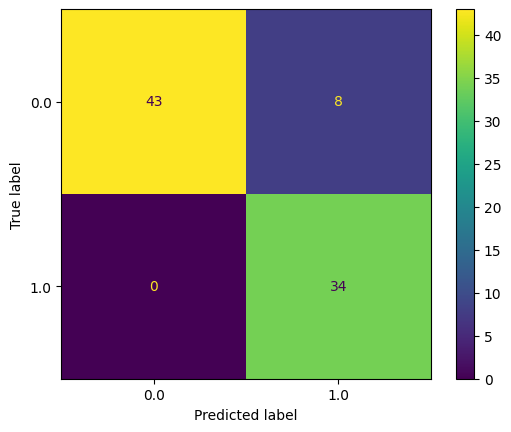

In [41]:
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_pred_prob);

In [42]:
# pretty much the same? but supposed to improve by changing threshold?

## Regression Example

What if we were predicting the cost of a burrito?


In [ ]:
# target = 'Cost'
# y = df[target]
# X = df.drop(columns=target)

In [ ]:
# df['Cost'].hist(bins=20) # to check for target skewness

In [ ]:
# Radomized Train Test Split
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# from sklearn.metrics import mean_absolute_error
# baseline_pred = [y_val.mean()] * len(y_val)
# mean_absolute_error(y_val, baseline_pred)

In [ ]:

# model_lr = make_pipeline(SimpleImputer(),
#                       StandardScaler(),
#                       LinearRegression())

# model_lr.fit(X_train, y_train)

In [ ]:

# model_rf = make_pipeline(SimpleImputer(),
#                       RandomForestRegressor())

# model_rf.fit(X_train, y_train)

In [ ]:
# print("Training Accuracy - Linear Regression", mean_absolute_error(y_train, model_lr.predict(X_train)))
# print("Validation Accuracy - Linear Regression", mean_absolute_error(y_val, model_lr.predict(X_val)))

In [ ]:
# print("Training Accuracy - Random Forest", mean_absolute_error(y_train, model_rf.predict(X_train)))
# print("Validation Accuracy - Random Forest", mean_absolute_error(y_val, model_rf.predict(X_val)))

# Log Transformation of skewed Target (for regression)

In [ ]:
# The chosen target for the above example (burrito cost) is not skewed. But if your regression target is skewed, then you should log transform it, using the following steps:

# log transform your target (training set) # use np.log or np.log1p to give you more accurate numbers for small numbers
# y_train_log = np.log1p(y_train)

# fit your chosen model to this log tranformed target
# model.fit(X_train, y_train_log)

# get your predictions for this log tranformed target
# y_pred_log = model.predict(X_val)

# reverse log tranform your log tranformed target
# y_pred = np.expm1(y_pred_log)

# check your metrics
# print(mean_absolute_error(y_val, y_pred))


# Sampling of imbalance data (using .sample function)

This is just one way to over or under sample. Go over these links and read how to implement SMOTE(Synthetic Minority Oversampling Technique) technique too, where you create synthetic observations of the minority class!

* https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html
* https://www.section.io/engineering-education/imbalanced-data-in-ml/

In [ ]:
# # Sampling of imbalance data (using .sample function)

# # If train_minority contains only those rows in your training dataset that correspond to minority class, you can oversample like this.
# # When you over sample your minority class, you always have to sample with replacement

# num_minority_samples = 10 # number of additional minority class rows to create.
# train_minority_sample = train_minority.sample(num_minority_samples,replace = True)


# # If train_majority contains only those rows in your dataset that correspond to majority class, you can undersample like this.
# # Under sampling doesnt need with replacement
# num_majority_samples = 10 # number of majority class rows to remove.
# train_majority_sample = train_majority.sample(num_majority_samples,replace=False)

# # You can then append the two dataframes to form a final train df.
# train_final = train_minority_sample.append(train_majority_sample, ignore_index=True)
